# Simulación de Arribos de Aviones a AEP

Este notebook contiene la resolución de los problemas planteados sobre simulación de arribos de aviones mediante métodos de Monte Carlo.  
Incluye experimentos con distintos valores de λ, análisis de congestión, desvíos y posibles políticas de control de tráfico aéreo.  

---
# Simulación de Arribos de Aviones a AEP

Este notebook contiene la resolución de los problemas planteados sobre simulación de arribos de aviones mediante métodos de Monte Carlo.  
Incluye experimentos con distintos valores de λ, análisis de congestión, desvíos y posibles políticas de control de tráfico aéreo.  

---

## 0. Setup de la simulación

En esta sección se definen:  
- Parámetros globales (velocidades, distancias, tiempos).  
- Funciones auxiliares (generar arribos, simular dinámica, métricas, visualización).  
- Una función principal `simular(...)` que permita correr la simulación variando λ y otras condiciones.  
De este modo, el resto de las secciones solo necesitan llamar a estas funciones.

In [125]:
# ==========================
# Simulación AEP — versión corregida y modular
# ==========================
import numpy as np
import random

# --------------------------
# Parámetros globales (unidades: distancia en mn, velocidad en nudos, tiempo en minutos)
# --------------------------
DISTANCIA_INICIAL = 100.0    # mn desde donde aparece el avión
VEL_MARCHA_ATRAS = 200.0     # nudos (velocidad absoluta de marcha atrás)
GAP_MIN = 4.0                # minutos (mínimo aceptable)
GAP_BUFFER = 5.0             # minutos (objetivo para buffer)
GAP_REINSERCION = 10.0       # minutos (gap mínimo para volver a entrar)
DT = 1                       # paso de simulación en minutos


In [126]:
# ==========================
# Clase Avion (autocontenida)
# ==========================
class Avion:
    def __init__(self, num, tiempo_radar, distancia_inicial=DISTANCIA_INICIAL):
        self.num = num
        self.tiempo_radar = int(tiempo_radar)
        self.posicion = float(distancia_inicial)  # mn desde AEP (0 = sobre AEP)
        self.atraso = 0
        self.desviado = False
        self.aterrizado = False
        self.estado = "en_vuelo"   # en_vuelo, marcha_atras, desviado, aterrizado
        self.MarchaAt = 0
        # velocidad_actual en nudos (por defecto velocidad máxima permitida en su banda)
        self.velocidad_actual = self.velocidad_permitida()[0]
        # historial: lista de (minuto, posicion_mn, velocidad_nudos)
        self.historial_posiciones = [(self.tiempo_radar, self.posicion, self.velocidad_actual)]

    def velocidad_permitida(self, distancia=None):
        """Devuelve (vel_max_knots, vel_min_knots) según la distancia a AEP."""
        d = self.posicion if distancia is None else distancia
        if d > 100.0:
            return 500.0, 300.0
        elif d > 50.0:
            return 300.0, 250.0
        elif d > 15.0:
            return 250.0, 200.0
        elif d > 5.0:
            return 200.0, 150.0
        else:
            return 150.0, 120.0

    def vel_max_actual(self):
        return self.velocidad_permitida()[0]

    def vel_min_actual(self):
        return self.velocidad_permitida()[1]

    def calcular_tiempo_esperado(self, distancia=None):
        """
        Tiempo estimado (en minutos) hasta aterrizar suponiendo que siempre
        va a la velocidad máxima permitida en cada tramo.
        """
        d = self.posicion if distancia is None else float(distancia)
        tiempo_total = 0
        # seguridad para evitar loops infinitos
        max_iter = 100000
        it = 0
        while d > 0 and it < max_iter:
            vel_max = self.velocidad_permitida(d)[0]  # nudos
            avance = vel_max / 60.0                    # mn por minuto
            if avance <= 0:
                # si por alguna razón avance 0, evitamos loop infinito
                return float('inf')
            d -= avance
            tiempo_total += 1
            it += 1
        return tiempo_total

    def avanzar_minuto(self, minuto, dt=DT):
        """Avanza el avión dt minutos según su velocidad_actual (si está en vuelo)."""
        # No avanzamos si ya aterrizó o desvió. Marcha atrás se procesa aparte.
        if self.aterrizado or self.desviado:
            # registramos posición (puede ser útil)
            self.historial_posiciones.append((minuto, self.posicion, self.velocidad_actual))
            return

        # Si está en marcha atrás no lo movemos aquí (se mueve en función específica)
        if self.estado == "marcha_atras":
            self.historial_posiciones.append((minuto, self.posicion, self.velocidad_actual))
            return

        vel = self.velocidad_actual if self.velocidad_actual is not None else self.vel_max_actual()
        if vel <= 0:
            # sin movimiento o error de signo
            self.historial_posiciones.append((minuto, self.posicion, vel))
            return

        avance = vel / 60.0 * dt   # nm recorridos hacia AEP en dt minutos
        self.posicion = max(0.0, self.posicion - avance)
        if self.posicion <= 0.0:
            self.posicion = 0.0
            self.aterrizado = True
            self.estado = "aterrizado"
            vel = 0
        # registrar
        self.historial_posiciones.append((minuto, self.posicion, vel))

    def __repr__(self):
        estado = "Aterrizado" if self.aterrizado else "Desviado" if self.desviado else self.estado
        return (f"Avion {self.num}: Pos={self.posicion:.2f} mn, Mins={self.tiempo_radar}, "
                f"estado={estado}, vel={self.velocidad_actual:.1f} kt")


In [127]:
# ==========================
# Generador de arribos (Poisson por minuto)
# ==========================
def generar_vuelos_poisson(lambda_hora, duracion_horas):
    """Genera minutos de aparición en radar (enteros) usando proceso Poisson homogéneo."""
    tiempos = []
    tiempo = 0.0
    lambda_min = float(lambda_hora) / 60.0
    total_min = int(duracion_horas * 60)
    while tiempo < total_min:
        # exponencial con media 1/lambda_min (en minutos)
        delta = np.random.exponential(1.0 / lambda_min) if lambda_min > 0 else float('inf')
        tiempo += delta
        if tiempo < total_min:
            tiempos.append(int(tiempo))
    return tiempos

# ==========================
# Funciones auxiliares de creación / resultados
# ==========================
def crear_aviones(lambda_hora, duracion_horas, distancia_inicial=DISTANCIA_INICIAL):
    tiempos = generar_vuelos_poisson(lambda_hora, duracion_horas)
    aviones = [Avion(num=i+1, tiempo_radar=t, distancia_inicial=distancia_inicial) for i, t in enumerate(tiempos)]
    return aviones

def inicializar_resultados():
    return {
        "trayectorias": {},
        "aterrizados": 0,
        "desviados": 0,
        "congestion": 0
    }

def seleccionar_aviones_en_vuelo(aviones, minuto):
    """Devuelve la lista de aviones que han aparecido y no han terminado aún.
       Además chequea si todos los aviones tienen el mismo minuto en el historial actual.
    """
    activos = [a for a in aviones if (not a.aterrizado) and (not a.desviado) and (a.tiempo_radar < minuto)]

    if activos:
        # usar set para ver los últimos minutos distintos
        ultimos = {a.historial_posiciones[-1][0] for a in activos if a.historial_posiciones}

        if len(ultimos) > 1:
            print(f"WARNING: minutos inconsistentes en tick {minuto}: {ultimos}")
            # mostrar qué aviones tienen qué minuto
            for a in activos:
                if a.historial_posiciones:
                    last_min = a.historial_posiciones[-1][0]
                    print(f"  Avion {a.num}: ultimo minuto={last_min}, pos={a.posicion}, estado={a.estado}")

    return activos

    


In [133]:
# ==========================
# Lógica central: actualizar aviones en vuelo (pasos 1..3)
# ==========================
def actualizar_aviones_en_vuelo(en_vuelo, minuto, duracion_horas, resultados, lista_marcha_atras):
    """
    1) Ver si cada avión puede llegar antes del cierre -> si no, desvío.
    2) Para los que quedan: ordenar por posición (más cerca primero), recorrer pares
       y medir separación temporal entre el más cerca (lead) y el siguiente (tail).
       - Si time_gap >= GAP_MIN -> mantener velocidad máxima.
       - Si time_gap < GAP_MIN -> tail reduce su velocidad a (lead.vel - 20).
         Si esa nueva velocidad < vel_min permitido -> tail pasa a marcha_atras.
    3) Avanzar minuto para los aviones que siguen en la fila.
    """
    # 0) ordenar por posición: más cerca (small pos) al inicio
    en_vuelo.sort(key=lambda a: a.posicion)

    # 1) chequeo de llegada antes del cierre
    removidos_por_desvio = []
    for avion in list(en_vuelo):
        tiempo_llegada_min = minuto + avion.calcular_tiempo_esperado()
        if tiempo_llegada_min > duracion_horas * 60:
            # no puede llegar antes de cierre -> desvío
            avion.desviado = True
            avion.estado = "desviado"
            resultados["desviados"] += 1
            removidos_por_desvio.append(avion)
    for r in removidos_por_desvio:
        if r in en_vuelo:
            en_vuelo.remove(r)

    # 2) recorrer la cola y ajustar velocidades / decidir marcha atrás
    en_vuelo_activos = []
    for idx, avion in enumerate(en_vuelo):
        if idx == 0:
            # primer avión: va a su velocidad máxima permitida
            avion.velocidad_actual = avion.vel_max_actual()
            en_vuelo_activos.append(avion)
            continue

        lead = en_vuelo_activos[-1]  # el avión que está más cerca de AEP en esta lista activa
        # calculamos distancia en nm entre lead y tail
        distancia_nm = avion.posicion - lead.posicion
        # velocidad de referencia conservadora: usamos la velocidad actual del lead si es > 0,
        # si no, usamos su velocidad máxima permitida
        vel_ref_lead = lead.velocidad_actual if lead.velocidad_actual and lead.velocidad_actual > 0 else lead.vel_max_actual()
        # tiempo de separación (minutos) estimado con vel_ref_lead
        time_sep_min = (distancia_nm / vel_ref_lead) * 60.0 if vel_ref_lead > 0 else float('inf')

        if time_sep_min >= GAP_MIN:
            # suficiente separación: tail va a su velocidad máxima permitida
            avion.estado = 'en_vuelo'
            avion.velocidad_actual = avion.vel_max_actual()
            en_vuelo_activos.append(avion)
        else:
            # congestión: tail reduce 20 nudos respecto del lead
            nueva_vel = max(0.0, vel_ref_lead - 20.0)
            vel_min_actual = avion.vel_min_actual()
            # si la nueva velocidad es menor que el mínimo permitido en esa banda -> marcha atrás
            if nueva_vel < vel_min_actual:
                # pasa a marcha atrás
                print('entra Marcha_atras: ', avion.num,'time sep: ', time_sep_min, 'a: ', lead.num, 'en pos:', avion.posicion)
                avion.estado = "marcha_atras"
                avion.velocidad_actual = -VEL_MARCHA_ATRAS  # indicador y valor absoluto (nudos)
                agregar_a_marcha_atras(lista_marcha_atras, avion)
                resultados["congestion"] += 1
                # remove by plane num instead of object identity
                en_vuelo = [a for a in en_vuelo if a.num != avion.num]

                # no lo añadimos a en_vuelo_activos (queda fuera de la fila)
            else:
                # puede reducir y permanecer en la fila
                # contemos congestión sólo cuando realmente se reduce respecto a su máxima
                if nueva_vel < avion.vel_max_actual():
                    resultados["congestion"] += 1
                avion.velocidad_actual = nueva_vel
                en_vuelo_activos.append(avion)

    # actualizamos la lista in-place (opcional)
    en_vuelo[:] = en_vuelo_activos

    # 3) Avanzar minuto para los aviones que están en la fila principal
    for avion in en_vuelo:
        avion.avanzar_minuto(minuto, dt=DT)

# ==========================
# Lógica de marcha atrás (paso 4)
# ==========================
def actualizar_marcha_atras(lista_marcha_atras, en_vuelo, minuto, resultados):
    """
    Para cada avión en lista_marcha_atras:
      - intenta encontrar un hueco (gap) entre dos aviones consecutivos en en_vuelo con
        separación >= GAP_REINSERCION. Si existe un hueco que permite un lugar donde
        el avión reinserte manteniendo GAP_BUFFER (5 min) con ambos vecinos, y si
        el avión puede alcanzar esa posición *en ESTE mismo minuto* viajando hacia atrás,
        lo colocamos ahí y lo reinsertamos.
      - si no puede alcanzarlo, avanza un minuto hacia afuera a VEL_MARCHA_ATRAS.
      - si sale de DISTANCIA_INICIAL -> se considera desviado (Montevideo) y se elimina.
    """
    reinsertados = []
    desviados = []
    avance_nm_por_min = VEL_MARCHA_ATRAS / 60.0

    # mantener en_vuelo ordenado por posicion (cerca primero)
    en_vuelo.sort(key=lambda a: a.posicion)
    lista_marcha_atras.sort(key=lambda a: a.posicion)
    # if len(lista_marcha_atras) >0:
    #     print(lista_marcha_atras)

    for avion in list(lista_marcha_atras):
        # 1) intentamos reinserción buscando gaps entre pares (lead, tail)
        inserted = False

        # caso general: hay al menos 2 en vuelo
        if len(en_vuelo) >= 2:
            for i in range(1, len(en_vuelo)):
                lead = en_vuelo[i - 1]
                tail = en_vuelo[i]

                # velocidad del lead en nm/min
                lead_spd_min = (lead.velocidad_actual if lead.velocidad_actual and lead.velocidad_actual > 0 
                                else lead.vel_max_actual()) / 60.0

                # posición objetivo: 5 min detrás del lead
                pos_objetivo = lead.posicion + lead_spd_min * GAP_BUFFER
                distancia_para_alcanzar = abs(pos_objetivo - avion.posicion)

                # el gap entre lead y tail tiene que ser >= GAP_REINSERCION
                distancia_gap_nm = tail.posicion - lead.posicion
                vel_ref_tail = (tail.velocidad_actual if tail.velocidad_actual and tail.velocidad_actual > 0 
                                else tail.vel_max_actual())
                tiempo_gap_min = (distancia_gap_nm / vel_ref_tail) * 60.0 if vel_ref_tail > 0 else float('inf')

                if tiempo_gap_min >= GAP_REINSERCION:
                    if distancia_para_alcanzar <= avance_nm_por_min:
                        # puede reintegrarse en este minuto justo detrás del lead
                        avion.posicion = pos_objetivo
                        avion.velocidad_actual = avion.vel_max_actual()
                        avion.estado = "en_vuelo"
                        avion.historial_posiciones.append((minuto, avion.posicion, avion.velocidad_actual))
                        en_vuelo.insert(i, avion)
                        reinsertados.append(avion)
                        inserted = True
                        break
                    else:
                        # no llega todavía, retrocede un poco más
                        avion.posicion += avance_nm_por_min
                        avion.historial_posiciones.append((minuto, avion.posicion, avion.velocidad_actual))

        elif len(en_vuelo) == 1:
            lead = en_vuelo[0]
            lead_spd_min = (lead.velocidad_actual if lead.velocidad_actual and lead.velocidad_actual > 0 else lead.vel_max_actual()) / 60.0

            # posición objetivo: al menos 5 minutos detrás del lead
            pos_objetivo = lead.posicion + lead_spd_min * GAP_BUFFER
            if avion.posicion >= pos_objetivo - avance_nm_por_min:
                # puede insertarse en este minuto
                avion.posicion = max(avion.posicion, pos_objetivo)
                avion.velocidad_actual = avion.vel_max_actual()
                avion.estado = "en_vuelo"
                avion.historial_posiciones.append((minuto, avion.posicion, avion.velocidad_actual))
                en_vuelo.append(avion)
                reinsertados.append(avion)
                inserted = True
                continue  # <- ya quedó en vuelo, no seguir procesando este avión
            else:
                # todavía no llega: sigue yéndose hacia afuera
                avion.posicion += avance_nm_por_min
                avion.historial_posiciones.append((minuto, avion.posicion, avion.velocidad_actual))


        else:
            # en_vuelo vacía: no hay aviones en cola -> podemos reintegrar como único avión si está dentro del horizonte
            # si puede alcanzar una posición válida (por ejemplo, quedarse en su posición actual) lo reinsertamos
            # definimos que si está dentro del horizonte lo reinsertamos inmediatamente
            if avion.posicion <= DISTANCIA_INICIAL:
                avion.velocidad_actual = avion.vel_max_actual()
                avion.estado = "en_vuelo"
                avion.historial_posiciones.append((minuto, avion.posicion, avion.velocidad_actual))
                en_vuelo.append(avion)
                reinsertados.append(avion)
                inserted = True
            else:
                avion.posicion += avance_nm_por_min
                avion.historial_posiciones.append((minuto, avion.posicion, avion.velocidad_actual))

        # 3) comprobación de salida fuera del horizonte
        if not inserted:
            # si después del movimiento (o porque no se insertó) el avión superó DISTANCIA_INICIAL -> desviado
            if avion.posicion > DISTANCIA_INICIAL:
                avion.desviado = True
                avion.estado = "desviado"
                desviados.append(avion)
                resultados["desviados"] += 1

    # limpiar la lista_marcha_atras: quitar los reinsertados y desviados
    for a in reinsertados + desviados:
        if a in lista_marcha_atras:
            lista_marcha_atras.remove(a)
    
    # limpieza final: quitar reinsertados, desviados y duplicados
    ids_en_vuelo = {a.num for a in en_vuelo}
    lista_marcha_atras[:] = [a for a in lista_marcha_atras if a.num not in ids_en_vuelo and not a.desviado]

    for avion in list(lista_marcha_atras):
        if avion.estado == "en_vuelo":
            print(f"ERROR: Avion {avion.num} sigue en lista_marcha_atras aunque ya está en vuelo")

   

def agregar_a_marcha_atras(lista_marcha_atras, avion):
    # si ya está, actualizamos sus datos
    for a in lista_marcha_atras:
        if a.num == avion.num:
            a.posicion = avion.posicion
            a.velocidad_actual = avion.velocidad_actual
            a.estado = "marcha_atras"
            a.MarchaAt = 1
            return
    # si no está, lo agregamos nuevo
    avion.estado = "marcha_atras"
    lista_marcha_atras.append(avion)


# ==========================
# Registrar resultados finales
# ==========================
def registrar_resultados(aviones, resultados):
    for avion in aviones:
        resultados["trayectorias"][avion.num] = {
            "arribo_radar": avion.tiempo_radar,
            "posiciones": avion.historial_posiciones.copy(),
            "desviado": avion.desviado,
            "aterrizado": avion.aterrizado,
            "marcha_at": avion.MarchaAt
        }

# ==========================
# Función principal de simulación
# ==========================
def simular_aeropuerto(lambda_hora, duracion_horas, distancia_inicial=DISTANCIA_INICIAL, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    aviones = crear_aviones(lambda_hora, duracion_horas, distancia_inicial)
    resultados = inicializar_resultados()
    lista_marcha_atras = []

    total_minutos = int(duracion_horas * 60)
    for minuto in range(total_minutos):
        # seleccionar los aviones que ya aparecieron y no terminaron
        en_vuelo = seleccionar_aviones_en_vuelo(aviones, minuto)
        # orden inicial (por si acaso)
        en_vuelo.sort(key=lambda a: a.posicion)

        # 1..3: check llegada/desvío, ajustar velocidades/marcha atrás, avanzar en_vuelo
        actualizar_aviones_en_vuelo(en_vuelo, minuto, duracion_horas, resultados, lista_marcha_atras)

        # 4: procesar marcha atrás (se accede a 'en_vuelo' para posibles reinserciones)
        actualizar_marcha_atras(lista_marcha_atras, en_vuelo, minuto, resultados)

    # registrar trayectorias finales
    registrar_resultados(aviones, resultados)
    resultados["aterrizados"] = sum(1 for a in aviones if a.aterrizado)
    resultados["desviados"] = sum(1 for a in aviones if a.desviado)
    return resultados, aviones


In [129]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def visualizar_trayectorias_horas(resultados, n=None, hora_final = 24):
    """
    Visualiza las trayectorias minuto a minuto de los aviones con eje X en formato hora,
    siempre desde 06:00 am hasta 00:00 am.
    Si un avión se desvía, se marca su última posición con un punto rojo.
    
    resultados: diccionario con 'trayectorias' de la simulación
    n: número máximo de aviones a mostrar. Si None, muestra todos
    """
    trayectorias = resultados['trayectorias']
    
    if n is not None:
        trayectorias = trayectorias[:n]
    
    plt.figure(figsize=(14,7))
    etiquetas_usadas = set()
    
    hora_inicio = datetime(2025, 1, 1, 6, 0)

    if hora_final == 24:
        hora_fin = datetime(2025, 1, 2, 0, 0)  # medianoche
    else:
        hora_fin = datetime(2025, 1, 1, 6+hora_final, 0)
    
    for num, t in resultados['trayectorias'].items():
        posiciones = t['posiciones']
        
        # Convertir a tuplas (minuto, distancia) si no lo es
        if len(posiciones) > 0 and isinstance(posiciones[0], (int, float)):
            posiciones = list(enumerate(posiciones))
        
        tiempos_min, distancias, vel = zip(*posiciones)
        tiempos = [hora_inicio + timedelta(minutes=m) for m in tiempos_min]
        
        if t.get('desviado', False):
            color = 'red'
            label = 'Desviado'
        elif t.get('marcha_at',True):
            color = 'orange'
        elif t.get('aterrizado', False):
            color = 'green'
            label = 'Aterrizado'
        else:
            color = 'blue'
            label = 'En vuelo'
        
        # Evitar repetir labels
        lbl = label if label not in etiquetas_usadas else None
        if lbl:
            etiquetas_usadas.add(label)
        
        # Dibujar la trayectoria
        plt.plot(tiempos, distancias, color=color, label=lbl)
        
        # Si se desvió, marcar el último punto
        if t.get('desviado', False):
            plt.scatter(tiempos[-1], distancias[-1], color='red', s=50, zorder=5)
        # print((t.get('marcha_at',True)))
    
    plt.xlabel("Hora")
    plt.ylabel("Distancia a AEP (mn)")
    plt.title("Trayectorias de aviones minuto a minuto")
    plt.gca().invert_yaxis()  # que AEP esté abajo
    plt.grid(True)
    
    # Eje X fijo de 06:00 a 00:00 con ticks cada 30 min
    plt.xlim(hora_inicio, hora_fin)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0,60,30)))
    plt.gcf().autofmt_xdate()
    
    plt.legend()
    plt.show()



## 1. Simulación de Monte Carlo básica de la fila de aviones

Implementar una simulación que modele la posición de cada avión en el tiempo y en el espacio, junto con un mecanismo de visualización.

In [134]:
timepo = 2
res, avs = simular_aeropuerto(lambda_hora=15, duracion_horas=timepo, seed=42)
print("Atterrizados:", res["aterrizados"])
print("Desviados:", res["desviados"])
print("Episodios de congestión (aprox):", res["congestion"])

print(res['trayectorias'][5])

entra Marcha_atras:  6 time sep:  0.9999999999999989 a:  5 en pos: 100.0
entra Marcha_atras:  7 time sep:  0.9999999999999989 a:  5 en pos: 100.0
entra Marcha_atras:  4 time sep:  3.959999999999992 a:  3 en pos: 62.3333333333333
  Avion 2: ultimo minuto=31, pos=16.66666666666667, estado=en_vuelo
  Avion 3: ultimo minuto=31, pos=41.66666666666667, estado=en_vuelo
  Avion 4: ultimo minuto=30, pos=62.3333333333333, estado=marcha_atras
  Avion 5: ultimo minuto=31, pos=64.33333333333336, estado=en_vuelo
entra Marcha_atras:  5 time sep:  0.7200000000000153 a:  4 en pos: 50.333333333333364
  Avion 2: ultimo minuto=35, pos=2.500000000000002, estado=en_vuelo
  Avion 3: ultimo minuto=35, pos=25.000000000000007, estado=en_vuelo
  Avion 4: ultimo minuto=35, pos=43.166666666666636, estado=en_vuelo
  Avion 5: ultimo minuto=34, pos=50.333333333333364, estado=marcha_atras
  Avion 8: ultimo minuto=35, pos=85.0, estado=en_vuelo
entra Marcha_atras:  5 time sep:  1.7200000000000149 a:  4 en pos: 50.333333

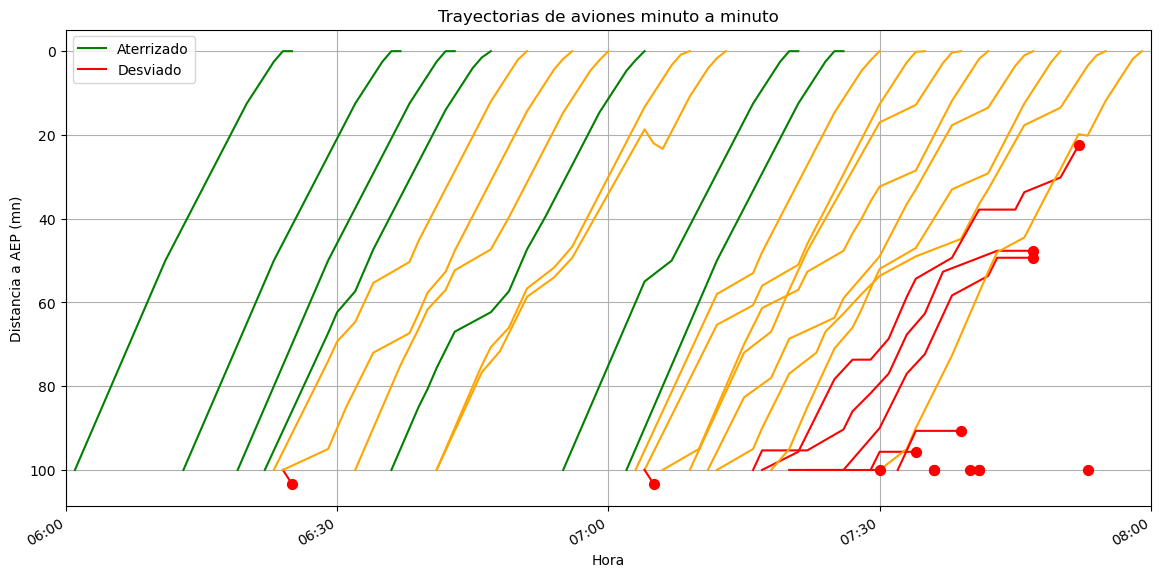

In [115]:
visualizar_trayectorias_horas(res, hora_final=timepo)

## 2. Cálculo de λ para 1 avión por hora

Si el promedio de arribos es de 1 avión por hora, determinar el valor de λ.


In [ ]:
# Código: cálculo de λ


## 3. Probabilidad de llegada de 5 aviones en una hora

- Usar simulación de Monte Carlo para estimar la probabilidad.  
- Verificar el resultado de manera analítica con la distribución de Poisson.


In [ ]:
# Código: simulación para estimar probabilidad


In [ ]:
# Código: verificación analítica usando Poisson


## 4. Congestión según distintos λ

Simular el sistema con λ ∈ {0.02, 0.1, 0.2, 0.5, 1}.  
Analizar:
- Frecuencia de congestión.  
- Atraso promedio de los aviones.  
- Frecuencia de desvíos a Montevideo.  
- Acompañar cada resultado con estimación de error.  
- Mostrar visualizaciones gráficas.


In [ ]:
# Código: simulación para distintos λ


In [ ]:
# Código: métricas de congestión y atrasos


In [ ]:
# Código: visualización comparativa


## 5. Escenario con día ventoso

Cada avión tiene 1/10 de probabilidad de tener que interrumpir su aterrizaje.  
Se debe simular:
- Estadísticas de atrasos en función de λ.  
- Desvíos a Montevideo.  
- Visualización de aviones (incluyendo los que se desvían).  
- Estimación de errores.


In [ ]:
# Código: simulación con interrupciones (día ventoso)


In [ ]:
# Código: métricas de performance bajo viento


In [ ]:
# Código: visualización de interrupciones y desvíos


## 6. Escenario con tormenta

Si AEP cierra sorpresivamente por 30 minutos:  
- Calcular consecuencias en desvíos, atrasos y otras métricas en función de λ.  
- Comparar con escenarios normales.


In [ ]:
# Código: simulación con cierre sorpresivo


In [ ]:
# Código: métricas y comparación con caso base


## 7. Políticas de vuelo alternativas

Explorar políticas simples basadas en información contemporánea (posiciones y velocidades actuales) para:  
- Reducir atrasos.  
- Disminuir o eliminar desvíos a Montevideo.  
- Analizar trade-off entre atraso promedio y frecuencia de desvíos.


In [ ]:
# Código: implementación de políticas alternativas


In [ ]:
# Código: evaluación de performance bajo políticas alternativas


## 8. Conclusiones

- Resumen de los principales hallazgos.  
- Comparación entre distintos escenarios de λ, viento y tormenta.  
- Discusión sobre posibles mejoras de políticas de control aéreo.


In [ ]:
# (Opcional) Gráficos finales comparativos / resumen visual
